Deep Learning With Keras
=====

##### Yam Peleg,  Valerio Maggio

Deep learning allows computational models that are composed of multiple processing layers to learn representations of data with multiple levels of abstraction. These methods have dramatically improved the state-of-the-art in speech recognition, visual object recognition, object detection and many other domains such as drug discovery and genomics. 

Deep learning is one of the leading tools in data analysis these days and one of the common frameworks for deep learning is Keras. The Tutorial will provide an introduction to keras with practical code examples.

##### ypeleg: https://github.com/ypeleg/deep-learning-keras-euroscipy2016

##### leriomaggio: https://github.com/leriomaggio/deep-learning-keras-euroscipy2016/

Part I: Introduction
=====

### Artificial Neural Networks

In machine learning and cognitive science, an artificial neural network (ANN) is a network inspired by biological neural networks which are used to estimate or approximate functions that can depend on a large number of inputs that are generally unknown

<img src ="imgs/perceptron.png" width="85%">

An ANN is built from nodes (neurons) stacked in layers between the feature vector and the target vector. 
A node in a neural network is built from Weights and Activation function and an early version of ANN built from one node was called "the perceptron"

The Perceptron is an algorithm for supervised learning of binary classifiers. functions that can decide whether an input (represented by a vector of numbers) belongs to one class or another.

Much like logistic regression, the weights in a neural net are being multiplied by the input vertor summed up and feeded into the activation function's input.

<img src ="imgs/backprop.png" width="80%">

The weights of each neuron are learned by gradient decent, where each neuron's error is derived with respect to it's weight.
Optimization is done for each layer with respect to the previous layer in a technique known as BackPropagation. 

## Intro to Theano

Dealing with weights matrices and gradients can be tricky and sometimes not trivial.
Theano is a great framework for handling vectors, matrices and high dimensional tensor algebra. 
Most of this tutorial will refer to Theano however TensorFlow is another great framework capable of providing an incredible abstraction for complex algebra.
More on TensorFlow in the next chapters.

### Warming up! Logistic Regression

In [3]:
%matplotlib inline

In [4]:
import numpy as np
import pandas as pd
import theano
import theano.tensor as T
import keras 
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.preprocessing import image
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt

from keras.datasets import imdb
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras.preprocessing import sequence
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM, GRU, SimpleRNN
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from keras.layers.core import Activation, TimeDistributedDense, RepeatVector
from keras.callbacks import EarlyStopping, ModelCheckpoint

For this section we will use the Kaggle otto challenge.
If you want to follow, Get the data from Kaggle: https://www.kaggle.com/c/otto-group-product-classification-challenge/data

#### About the data

The Otto Group is one of the world’s biggest e-commerce companies, A consistent analysis of the performance of products is crucial. However, due to diverse global infrastructure, many identical products get classified differently.
For this competition, we have provided a dataset with 93 features for more than 200,000 products. The objective is to build a predictive model which is able to distinguish between our main product categories. 
Each row corresponds to a single product. There are a total of 93 numerical features, which represent counts of different events. All features have been obfuscated and will not be defined any further.

https://www.kaggle.com/c/otto-group-product-classification-challenge/data

In [5]:
def load_data(path, train=True):
    """Load data from a CSV File
    
    Parameters
    ----------
    path: str
        The path to the CSV file
        
    train: bool (default True)
        Decide whether or not data are *training data*.
        If True, some random shuffling is applied.
        
    Return
    ------
    X: numpy.ndarray 
        The data as a multi dimensional array of floats
    ids: numpy.ndarray
        A vector of ids for each sample
    """
    df = pd.read_csv(path)
    X = df.values.copy()
    if train:
        np.random.shuffle(X)  # https://youtu.be/uyUXoap67N8
        X, labels = X[:, 1:-1].astype(np.float32), X[:, -1]
        return X, labels
    else:
        X, ids = X[:, 1:].astype(np.float32), X[:, 0].astype(str)
        return X, ids

In [6]:
def preprocess_data(X, scaler=None):
    """Preprocess input data by standardise features 
    by removing the mean and scaling to unit variance"""
    if not scaler:
        scaler = StandardScaler()
        scaler.fit(X)
    X = scaler.transform(X)
    return X, scaler


def preprocess_labels(labels, encoder=None, categorical=True):
    """Encode labels with values among 0 and `n-classes-1`"""
    if not encoder:
        encoder = LabelEncoder()
        encoder.fit(labels)
    y = encoder.transform(labels).astype(np.int32)
    if categorical:
        y = np_utils.to_categorical(y)
    return y, encoder

In [7]:
print("Loading data...")
X, labels = load_data('train.csv', train=True)
X, scaler = preprocess_data(X)
Y, encoder = preprocess_labels(labels)


X_test, ids = load_data('test.csv', train=False)
X_test, ids = X_test[:1000], ids[:1000]

#Plotting the data
print(X_test[:1])
print(Y_test[:1])

X_test, _ = preprocess_data(X_test, scaler)

nb_classes = Y.shape[1]
print(nb_classes, 'classes')

dims = X.shape[1]
print(dims, 'dims')

Loading data...


OSError: File b'train.csv' does not exist

Now lets create and train a logistic regression model.

#### Hands On - Logistic Regression

In [3]:
#Based on example from DeepLearning.net
rng = np.random
N = 400
feats = 93
D = (rng.randn(N, feats), rng.randint(size=N, low=0, high=2))
training_steps = 1

# Declare Theano symbolic variables
x = T.matrix("x")
y = T.vector("y")
w = theano.shared(rng.randn(feats), name="w")
b = theano.shared(0., name="b")

# Construct Theano expression graph
p_1 = 1 / (1 + T.exp(-T.dot(x, w) - b))   # Probability that target = 1
prediction = p_1 > 0.5                    # The prediction thresholded
xent = -y * T.log(p_1) - (1-y) * T.log(1-p_1) # Cross-entropy loss function
cost = xent.mean() + 0.01 * (w ** 2).sum()# The cost to minimize
gw, gb = T.grad(cost, [w, b])             # Compute the gradient of the cost
                                          # (we shall return to this in a
                                          # following section of this tutorial)

# Compile
train = theano.function(
          inputs=[x,y],
          outputs=[prediction, xent],
          updates=((w, w - 0.1 * gw), (b, b - 0.1 * gb)),
          allow_input_downcast=True)
predict = theano.function(inputs=[x], outputs=prediction, allow_input_downcast=True)

#Transform for class1
y_class1 = []
for i in Y:
    y_class1.append(i[0])
y_class1 = np.array(y_class1)

# Train
for i in range(training_steps):
    print('Epoch %s' % (i,))
    pred, err = train(X, y_class1)

print("target values for Data:")
print(y_class1)
print("prediction on D:")
print(predict(X))

Epoch 0
target values for Data:
[ 0.  0.  0. ...,  0.  0.  0.]
prediction on D:
[0 0 0 ..., 0 0 0]


### Keras: Deep Learning library for Theano and TensorFlow

Keras is a minimalist, highly modular neural networks library, written in Python and capable of running on top of either TensorFlow or Theano. It was developed with a focus on enabling fast experimentation. Being able to go from idea to result with the least possible delay is key to doing good research.
ref: https://keras.io/

#### Hands On - Keras Logistic Regression


In [4]:
dims = X.shape[1]
print(dims, 'dims')
print("Building model...")

nb_classes = Y.shape[1]
print(nb_classes, 'classes')

model = Sequential()
model.add(Dense(nb_classes, input_shape=(dims,)))
model.add(Activation('softmax'))
model.compile(optimizer='sgd', loss='categorical_crossentropy')
model.fit(X, Y)

93 dims
Building model...
9 classes
Epoch 1/10
61878/61878 [==============================] - 1s - loss: 1.0863     
Epoch 2/10
61878/61878 [==============================] - 1s - loss: 0.7774     
Epoch 3/10
61878/61878 [==============================] - 2s - loss: 0.7325     
Epoch 4/10
61878/61878 [==============================] - 2s - loss: 0.7105     
Epoch 5/10
61878/61878 [==============================] - 1s - loss: 0.6966     
Epoch 6/10
61878/61878 [==============================] - 1s - loss: 0.6870     
Epoch 7/10
61878/61878 [==============================] - 1s - loss: 0.6800     
Epoch 8/10
61878/61878 [==============================] - 1s - loss: 0.6746     
Epoch 9/10
61878/61878 [==============================] - 1s - loss: 0.6701     
Epoch 10/10
61878/61878 [==============================] - 1s - loss: 0.6667     


Simplicity is pretty impressive right? :)

Now lets understand:
<pre>The core data structure of Keras is a <b>model</b>, a way to organize layers. The main type of model is the <b>Sequential</b> model, a linear stack of layers.</pre>


What we did here is stacking a Fully Connected (<b>Dense</b>) layer of trainable weights from the input to the output and an <b>Activation</b> layer on top of the weights layer.

##### Dense

```python
from keras.layers import core

core.Dense(output_dim, init='glorot_uniform', activation='linear', weights=None, W_regularizer=None, b_regularizer=None, activity_regularizer=None, W_constraint=None, b_constraint=None, bias=True, input_dim=None)

```

##### Activation

In [ ]:
keras.layers.core.Activation(activation)

##### Optimizer

If you need to, you can further configure your optimizer. A core principle of Keras is to make things reasonably simple, while allowing the user to be fully in control when they need to (the ultimate control being the easy extensibility of the source code).
Here we used <b>SGD</b> (stochastic gradient descent) as an optimization algorithm for our trainable weights.  

"Data Sciencing" this example a little bit more
=====

What we did here is nice, however in the real world it is not useable because of overfitting.
Lets try and solve it with cross validation.

##### Overfitting

In overfitting, a statistical model describes random error or noise instead of the underlying relationship. Overfitting occurs when a model is excessively complex, such as having too many parameters relative to the number of observations. 

A model that has been overfit has poor predictive performance, as it overreacts to minor fluctuations in the training data.


<img src ="imgs/overfitting.png">

<pre>To avoid overfitting, we will first split out data to training set and test set and test out model on the test set.
Next: we will use two of keras's callbacks <b>EarlyStopping</b> and <b>ModelCheckpoint</b></pre>

In [13]:
X, X_test, Y, Y_test = train_test_split(X, Y, test_size=0.15, random_state=42)

fBestModel = 'best_model.h5'  # THIS FILE IS MISSING from the REPO
early_stop = EarlyStopping(monitor='val_loss', patience=4, verbose=1) 
best_model = ModelCheckpoint(fBestModel, verbose=0, save_best_only=True)
model.fit(X, Y, validation_data = (X_test, Y_test), nb_epoch=20, 
          batch_size=128, verbose=True, validation_split=0.15, 
          callbacks=[best_model, early_stop])  # here the Callbacks hook!

Train on 19835 samples, validate on 3501 samples
Epoch 1/20
19835/19835 [==============================] - 0s - loss: 0.6391 - val_loss: 0.6680
Epoch 2/20
19835/19835 [==============================] - 0s - loss: 0.6386 - val_loss: 0.6689
Epoch 3/20
19835/19835 [==============================] - 0s - loss: 0.6384 - val_loss: 0.6695
Epoch 4/20
19835/19835 [==============================] - 0s - loss: 0.6381 - val_loss: 0.6702
Epoch 5/20
19835/19835 [==============================] - 0s - loss: 0.6378 - val_loss: 0.6709
Epoch 6/20
19835/19835 [==============================] - 0s - loss: 0.6375 - val_loss: 0.6716


Part II: Supervised Learning + Keras Internals
=====

### Multi-Layer Perceptron and Fully Connected

So, how hard can it be to build a Multi-Layer percepton with keras?
It is baiscly the same, just add more layers!

In [ ]:
model = Sequential()
model.add(Dense(100, input_shape=(dims,)))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))
model.compile(optimizer='sgd', loss='categorical_crossentropy')
model.fit(X, Y)

Your Turn!

#### Hands On - Keras Fully Connected


Take couple of minutes and Try and optimize the number of layers and the number of parameters in the layers to get the best results. 

In [ ]:
model = Sequential()
model.add(Dense(100, input_shape=(dims,)))

# ...
# ...
# Play with it! add as much layers as you want! try and get better results.

model.add(Dense(nb_classes))
model.add(Activation('softmax'))
model.compile(optimizer='sgd', loss='categorical_crossentropy')
model.fit(X, Y)

Building a question answering system, an image classification model, a Neural Turing Machine, a word2vec embedder or any other model is just as fast. The ideas behind deep learning are simple, so why should their implementation be painful?

#### Theoretical Motivations for depth

>Much has been studied about the depth of neural nets. Is has been proven mathematicly[1] and ampirically that convolutional neural network benifit from depth! however there is no evidence that a fully connected deep net benifit from depth more then width. 

[1] - On the Expressive Power of Deep Learning: A Tensor Analysis - Cohen, et al 2015

#### Theoretical Motivations for depth

One much quoted theorem about neural network states that:

>Universal approximation theorem states[1] that a feed-forward network with a single hidden layer containing a finite number of neurons (i.e., a multilayer perceptron), can approximate continuous functions on compact subsets of Rn, under mild assumptions on the activation function. The theorem thus states that simple neural networks can represent a wide variety of interesting functions when given appropriate parameters; however, it does not touch upon the algorithmic learnability of those parameters.

[1] - Approximation Capabilities of Multilayer Feedforward Networks - Kurt Hornik 1991

## Convolutional Neural Network 

A convolutional neural network (CNN, or ConvNet) is a type of feed-forward artificial neural network in which the connectivity pattern between its neurons is inspired by the organization of the animal visual cortex.

The networks consist of multiple layers of small neuron collections which process portions of the input image, called receptive fields. The outputs of these collections are then tiled so that their input regions overlap, to obtain a better representation of the original image; this is repeated for every such layer.


<img src ="imgs/conv.png" width="50%">

#### Convolutional filters


A Convolutional Filter much like a kernel in image recognition is a small matrix useful for blurring, sharpening, embossing, edge detection, and more. This is accomplished by means of convolution between a kernel and an image.

The main difference here is that the conv matrices are learned. 

<img src="imgs/keDyv.png">

### Dimensions of Conv filters


This complex structure leads to a challenging representation, In Keras the input tensor to the 2D convolution layer is a 4D Tensor with the shape: (samples, channels, rows, cols)

#### Convolution in Keras


In [ ]:
keras.layers.convolutional.Convolution2D(nb_filter, nb_row, 
                                         nb_col, init='glorot_uniform', 
                                         activation='linear', weights=None, 
                                         border_mode='valid', subsample=(1, 1), dim_ordering='default', 
                                         W_regularizer=None, b_regularizer=None, activity_regularizer=None, 
                                         W_constraint=None, b_constraint=None, bias=True)

Convolution operator for filtering windows of two-dimensional inputs. When using this layer as the first layer in a model, provide the keyword argument input_shape (tuple of integers, does not include the sample axis), e.g. input_shape=(3, 128, 128) for 128x128 RGB pictures.

#### Max/Avg Pooling

Pooling layer is frequently used in convulational neural networks with the purpose to progressively reduce the spatial size of the representation to reduce the amount of features and the computational complexity of the network.

An intuitive explanation for the usefulness of pooing is that it is used to generalize feature location in an image. 
for example: lets assume that we have a filter that is used for detecting faces, the exact pixel location of the face is less relevant then the fact that there is a face "somewhere at the top"  

#### Hands On - ConvNet with keras


#### MNist

The MNIST database of handwritten digits, available from this page, has a training set of 60,000 examples, and a test set of 10,000 examples. It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image.
It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting.

http://yann.lecun.com/exdb/mnist/

#### Data Preparation 


X_train shape: (60000L, 1L, 28L, 28L)
60000 train samples
10000 test samples


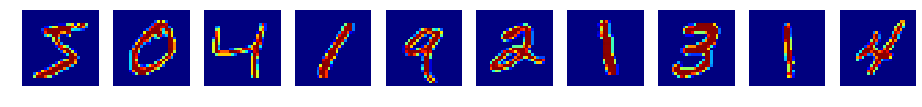

In [6]:
batch_size = 128
nb_classes = 10

# input image dimensions
img_rows, img_cols = 28, 28
# number of convolutional filters to use
nb_filters = 32
# size of pooling area for max pooling
nb_pool = 2
# convolution kernel size
nb_conv = 3

# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

unshaped_test = X_test
plt.figure(figsize=(16,8))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_train[i], interpolation='nearest')
    plt.axis('off')
    
X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

##### Optional: slice the training and test set so you can train faster during the tutorial 

In [3]:
X_train = X_train[:1000]
X_test = X_test[:300]
Y_train = Y_train[:1000]
Y_test = Y_test[:300]

print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

1000 train samples
300 test samples


#### ConvNet with keras


In [4]:
model = Sequential()
model.add(Convolution2D(nb_filters, nb_conv, nb_conv,
                        border_mode='valid',
                        input_shape=(1, img_rows, img_cols)))
model.add(Activation('relu'))
model.add(Convolution2D(nb_filters, nb_conv, nb_conv))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=1,
          verbose=1, validation_data=(X_test, Y_test))
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Train on 1000 samples, validate on 300 samples
Epoch 1/1
1000/1000 [==============================] - 136s - loss: nan - acc: 0.0910 - val_loss: nan - val_acc: 0.0800
Test score: nan
Test accuracy: 0.08


#### Lets plot our model predictions!

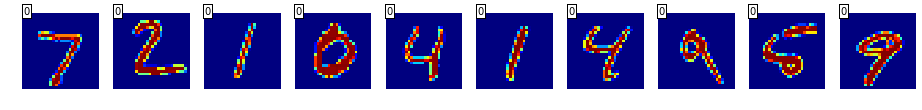

In [7]:
predicted = model.predict(X_test[:10]).argmax(-1)


plt.figure(figsize=(16,8))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(unshaped_test[i], interpolation='nearest')
    plt.text(0, 0, predicted[i], color='black', bbox=dict(facecolor='white', alpha=1))
    plt.axis('off')

#### Your Turn! Hands on CNN


In [ ]:
model = Sequential()
model.add(Convolution2D(nb_filters, nb_conv, nb_conv,
                        border_mode='valid',
                        input_shape=(1, img_rows, img_cols)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))

# ...
# ...
# Play with it! add as much layers as you want! try and get better results.

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=nb_epoch,
          verbose=1, validation_data=(X_test, Y_test))
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Train on 1000 samples, validate on 300 samples
Epoch 1/12
1000/1000 [==============================] - 131s - loss: nan - acc: 0.1020 - val_loss: nan - val_acc: 0.0800
Epoch 2/12
1000/1000 [==============================] - 139s - loss: nan - acc: 0.0970 - val_loss: nan - val_acc: 0.0800
Epoch 3/12
1000/1000 [==============================] - 128s - loss: nan - acc: 0.0970 - val_loss: nan - val_acc: 0.0800
Epoch 4/12
 256/1000 [======>.......................] - ETA: 93s - loss: nan - acc: 0.0742 

### Advanced CNN  

#### Dropout

Dropout consists in randomly setting a fraction p of input units to 0 at each update during training time, which helps prevent overfitting.

In [ ]:
keras.layers.core.Dropout(p)

#### BatchNorm

Normalize the activations of the previous layer at each batch, i.e. applies a transformation that maintains the mean activation close to 0 and the activation standard deviation close to 1.

In [ ]:
keras.layers.normalization.BatchNormalization(epsilon=1e-06, mode=0, 
                                              axis=-1, momentum=0.99, 
                                              weights=None, beta_init='zero', 
                                              gamma_init='one')

#### Your Turn! Hands on CNN with Dropout and BatchNorm


In [ ]:
model = Sequential()
model.add(Convolution2D(nb_filters, nb_conv, nb_conv,
                        border_mode='valid',
                        input_shape=(1, img_rows, img_cols)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))

#
# model.add(Dropout(PROBA)) 
# model.add(BatchNormalization()) 
# ...
# ...
# Play with it! Try Get Better Results! 

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=nb_epoch,
          verbose=1, validation_data=(X_test, Y_test))
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Train on 1000 samples, validate on 300 samples
Epoch 1/12
1000/1000 [==============================] - 131s - loss: nan - acc: 0.1020 - val_loss: nan - val_acc: 0.0800
Epoch 2/12
1000/1000 [==============================] - 139s - loss: nan - acc: 0.0970 - val_loss: nan - val_acc: 0.0800
Epoch 3/12
1000/1000 [==============================] - 128s - loss: nan - acc: 0.0970 - val_loss: nan - val_acc: 0.0800
Epoch 4/12
 256/1000 [======>.......................] - ETA: 93s - loss: nan - acc: 0.0742 

### Practical Deep Learning 

Constructing and training your own ConvNet from scratch can be Hard and a long task.
A common trick used in Deep Learning is to use a pretrained model and finetune it to the specific data it will be used for. 

#### Famous Models with Keras



In [ ]:
model = VGG16(weights='imagenet', include_top=False)

img_path = 'elephant.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

features = model.predict(x)

### Hands On - Famous Models with Keras



In [ ]:
# Do the same for a different model 

Part III: Unsupervised Learning + Keras Internals
=====

### AutoEncoders  

An autoencoder, is an artificial neural network used for learning efficient codings. 

The aim of an autoencoder is to learn a representation (encoding) for a set of data, typically for the purpose of dimensionality reduction. 

<img src ="imgs/AutoEncoder.png" width="25%">

### word2vec & doc2vec  

Word2vec is a group of related models that are used to produce word embeddings. These models are shallow, two-layer neural networks that are trained to reconstruct linguistic contexts of words.

### Embedding  

Word embedding is the collective name for a set of language modeling and feature learning techniques in natural language processing (NLP) where words or phrases from the vocabulary are mapped to vectors of real numbers in a low-dimensional space relative to the vocabulary size 

The Embedding Layer: Turns positive integers into dense vectors of fixed size.

In [ ]:
keras.layers.embeddings.Embedding(input_dim, output_dim, 
                                  init='uniform', input_length=None, 
                                  W_regularizer=None, activity_regularizer=None, 
                                  W_constraint=None, mask_zero=False, 
                                  weights=None, dropout=0.0)

Part IV: Recurrent Neural networks
=====

### RNN  

<img src ="imgs/rnn.png" width="20%">

A recurrent neural network (RNN) is a class of artificial neural network where connections between units form a directed cycle. This creates an internal state of the network which allows it to exhibit dynamic temporal behavior.

In [ ]:
keras.layers.recurrent.SimpleRNN(output_dim, 
                                 init='glorot_uniform', inner_init='orthogonal', activation='tanh', 
                                 W_regularizer=None, U_regularizer=None, b_regularizer=None, 
                                 dropout_W=0.0, dropout_U=0.0)

#### Backprop Through time  

Contrary to feed-forward neural networks, the RNN is characterized by the ability of encoding longer past information, thus very suitable for sequential models. The BPTT extends the ordinary BP algorithm to suit the recurrent neural
architecture.

<img src ="imgs/rnn2.png" width="45%">

#### IMDB sentiment classification task

This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. 

IMDB provided a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. 

There is additional unlabeled data for use as well. Raw text and already processed bag of words formats are provided. 

http://ai.stanford.edu/~amaas/data/sentiment/

#### Data Preparation - IMDB

In [13]:
max_features = 20000
maxlen = 100  # cut texts after this number of words (among top max_features most common words)
batch_size = 32

print("Loading data...")
(X_train, y_train), (X_test, y_test) = imdb.load_data(nb_words=max_features, test_split=0.2)
print(len(X_train), 'train sequences')
print(len(X_test), 'test sequences')

print('Example:')
print(X_train[:1])
print(Y_train[:1])

print("Pad sequences (samples x time)")
X_train = sequence.pad_sequences(X_train, maxlen=maxlen)
X_test = sequence.pad_sequences(X_test, maxlen=maxlen)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

Loading data...
20000 train sequences
5000 test sequences
Example:
[ [1, 20, 28, 716, 48, 495, 79, 27, 493, 8, 5067, 7, 50, 5, 4682, 13075, 10, 5, 852, 157, 11, 5, 1716, 3351, 10, 5, 500, 7308, 6, 33, 256, 41, 13610, 7, 17, 23, 48, 1537, 3504, 26, 269, 929, 18, 2, 7, 2, 4284, 8, 105, 5, 2, 182, 314, 38, 98, 103, 7, 36, 2184, 246, 360, 7, 19, 396, 17, 26, 269, 929, 18, 1769, 493, 6, 116, 7, 105, 5, 575, 182, 27, 5, 1002, 1085, 130, 62, 17, 24, 89, 17, 13, 381, 1421, 8, 5167, 7, 5, 2723, 38, 325, 7, 17, 23, 93, 9, 156, 252, 19, 235, 20, 28, 5, 104, 76, 7, 17, 169, 35, 14764, 17, 23, 1460, 7, 36, 2184, 934, 56, 2134, 6, 17, 891, 214, 11, 5, 1552, 6, 92, 6, 33, 256, 82, 7]]
[[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]]
Pad sequences (samples x time)
X_train shape: (20000L, 100L)
X_test shape: (5000L, 100L)


#### Model building 

In [3]:
print('Build model...')
model = Sequential()
model.add(Embedding(max_features, 128, input_length=maxlen))
model.add(SimpleRNN(128))  
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy', optimizer='adam', class_mode="binary")

print("Train...")
model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=4, validation_data=(X_test, y_test), show_accuracy=True)
score, acc = model.evaluate(X_test, y_test, batch_size=batch_size, show_accuracy=True)
print('Test score:', score)
print('Test accuracy:', acc)

Build model...


NameError: name 'Sequential' is not defined

### LSTM  

A LSTM network is an artificial neural network that contains LSTM blocks instead of, or in addition to, regular network units. A LSTM block may be described as a "smart" network unit that can remember a value for an arbitrary length of time. 

Unlike traditional RNNs, an Long short-term memory network is well-suited to learn from experience to classify, process and predict time series when there are very long time lags of unknown size between important events.

<img src ="imgs/gru.png" width="60%">

In [ ]:
keras.layers.recurrent.LSTM(output_dim, init='glorot_uniform', inner_init='orthogonal', 
                            forget_bias_init='one', activation='tanh', 
                            inner_activation='hard_sigmoid', 
                            W_regularizer=None, U_regularizer=None, b_regularizer=None, 
                            dropout_W=0.0, dropout_U=0.0)

### GRU  

Gated recurrent units are a gating mechanism in recurrent neural networks. 

Much similar to the LSTMs, they have fewer parameters than LSTM, as they lack an output gate.

In [ ]:
keras.layers.recurrent.GRU(output_dim, init='glorot_uniform', inner_init='orthogonal', 
                           activation='tanh', inner_activation='hard_sigmoid', 
                           W_regularizer=None, U_regularizer=None, b_regularizer=None, 
                           dropout_W=0.0, dropout_U=0.0)

### Your Turn! - Hands on Rnn

In [ ]:
print('Build model...')
model = Sequential()
model.add(Embedding(max_features, 128, input_length=maxlen))

# Play with those! try and get better results!
#model.add(SimpleRNN(128))  
#model.add(GRU(128))  
#model.add(LSTM(128))  

model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy', optimizer='adam', class_mode="binary")

print("Train...")
model.fit(X_train, y_train, batch_size=batch_size, 
          nb_epoch=4, validation_data=(X_test, y_test), show_accuracy=True)
score, acc = model.evaluate(X_test, y_test, batch_size=batch_size, show_accuracy=True)
print('Test score:', score)
print('Test accuracy:', acc)

Build model...
Train...
Train on 20000 samples, validate on 5000 samples
Epoch 1/4
20000/20000 [==============================] - 114s - loss: 0.7313 - val_loss: 0.6910
Epoch 2/4
20000/20000 [==============================] - 122s - loss: 0.7034 - val_loss: 0.6846
Epoch 3/4
20000/20000 [==============================] - 112s - loss: 0.6262 - val_loss: 0.5668
Epoch 4/4
20000/20000 [==============================] - 114s - loss: 0.5075 - val_loss: 0.5425

Keras Sprint
=====

##### Enjoyed Keras? You are not alone! :)

Keras Dev and Users are rich and live communities comunicating though Git, Google Group and slack and we are always looking for new folks to join us and contribute! 

<img src ="imgs/sprint.jpg">

**You are invited to come and contribute at the Keras sprint this week!**